# Table of Contents
 <p><div class="lev1"><a href="#Data-pre-processing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre-processing</a></div><div class="lev2"><a href="#Data-import"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data import</a></div><div class="lev2"><a href="#Remove-questionable-data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Remove questionable data</a></div><div class="lev2"><a href="#Create-X-and-Y-arrays-for-each-school-district"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create X and Y arrays for each school district</a></div><div class="lev2"><a href="#Boundaries"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Boundaries</a></div><div class="lev1"><a href="#Model-with-fied-hyperparameters"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model with fied hyperparameters</a></div><div class="lev2"><a href="#Fit-GPs-for-each-district"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit GPs for each district</a></div><div class="lev2"><a href="#2GP-posterior"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2GP posterior</a></div><div class="lev2"><a href="#Inverse-Variance"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inverse-Variance</a></div><div class="lev1"><a href="#Incorporating-covariates"><span class="toc-item-num">3&nbsp;&nbsp;</span>Incorporating covariates</a></div><div class="lev1"><a href="#Hyperparameters"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameters</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data pre-processing
## Data import

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar, 
    :PersonalProperty, 
    :PartialInterest])

In [3]:
print(names(Tucson_sales))

[:x,:ADDRESS,:ADPARCEL_,:ADPARCEL_I,:ADR_ID,:AD_STREET,:AD_SUFFIX,:ANGLE,:AREA,:CITY_ID,:CODE,:DATE_ENTER,:LAT,:LON,:PERIMETER,:POLYGONID,:SCALE,:SOURCE,:STATUS,:STREET,:STREET_DIR,:STREET_IDX,:STREET_NAM,:STREET_NO,:SUFFIX_DIR,:TILE_NAME,:X_HPGN,:Y_HPGN,:ZIPCITY,:ZIPCODE,:geometry,:SequenceNum,:SaleDate,:SalePrice,:PropertyType,:IntendedUse,:Deed,:Financing,:ValidationDescription,:BuyerSellerRelated,:Solar,:PersonalProperty,:PartialInterest,:RecordingDate,:SchDistr,:X_PRJ,:Y_PRJ]

## Remove questionable data

In [4]:
levels(Tucson_sales[:,:ValidationDescription])

23-element Array{UTF8String,1}:
 "Buyer/Seller are related parties or corporate entities" 
 "Buyer/Seller has an Out-Of-State Address"               
 "Buyer/Seller is a Non-Profit institution"               
 "Correction of previously recorded deed"                 
 "Developers discount/value by Land manual"               
 "Good Sale"                                              
 "Improvements not yet on assessment roll"                
 "Internet sale"                                          
 "More than five (5) parcels being sold"                  
 "Name/Address of Buyer or Seller is missing"             
 "Property altered since date of sale"                    
 "Property type/use code are not consistent"              
 "Sale by subsidiary corp. to parent corp."               
 "Sale includes quantifiable Personal Property > 5%"      
 "Sale includes unquantifiable Personal Property > 5%"    
 "Sale of partial interest"                               
 "Sale price missing"   

In [5]:
levels(Tucson_sales[:,:PropertyType])

8-element Array{UTF8String,1}:
 "2-4 Plex"             
 "Apartment Building"   
 "Commercial/Industrial"
 "Condo/Townhouse"      
 "Mobile Home"          
 "Other"                
 "Single Family"        
 "Vacant Land"          

In [6]:
believable = (
      (Tucson_sales[:,:BuyerSellerRelated].=="No") 
    & (Tucson_sales[:,:PartialInterest].=="No")
    & [x in ("2-4 Plex", "Condo/Townhouse", "Single Family") # debatable choice?
            for x in Tucson_sales[:,:PropertyType]]
    & (Tucson_sales[:,:ValidationDescription].=="Good Sale")
    
)
believable[isna(believable)]=false
believable=believable.refs.==2

8759-element BitArray{1}:
 false
  true
 false
  true
  true
  true
  true
  true
  true
  true
  true
  true
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
  true
 false

## Create X and Y arrays for each school district

In [7]:
Y_dict=Dict{UTF8String, Vector{Float64}}()
X_dict=Dict{UTF8String, Array{Float64,2}}()

Dict{UTF8String,Array{Float64,2}} with 0 entries

In [8]:
schdistrs = unique(Tucson_sales[:,:SchDistr])

6-element DataArrays.DataArray{UTF8String,1}:
 "Flowing Wells Unified District"
 "Tucson Unified District"       
 "Amphitheater Unified District" 
 "Sunnyside Unified District"    
 "Vail Unified District"         
 "Tanque Verde Unified District" 

In [9]:
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[(Tucson_sales[:,:SchDistr] .== name) & believable,:SalePrice])
    X_dict[name] = Tucson_sales[(Tucson_sales[:,:SchDistr] .== name) & believable,[:X_PRJ, :Y_PRJ]]'
end

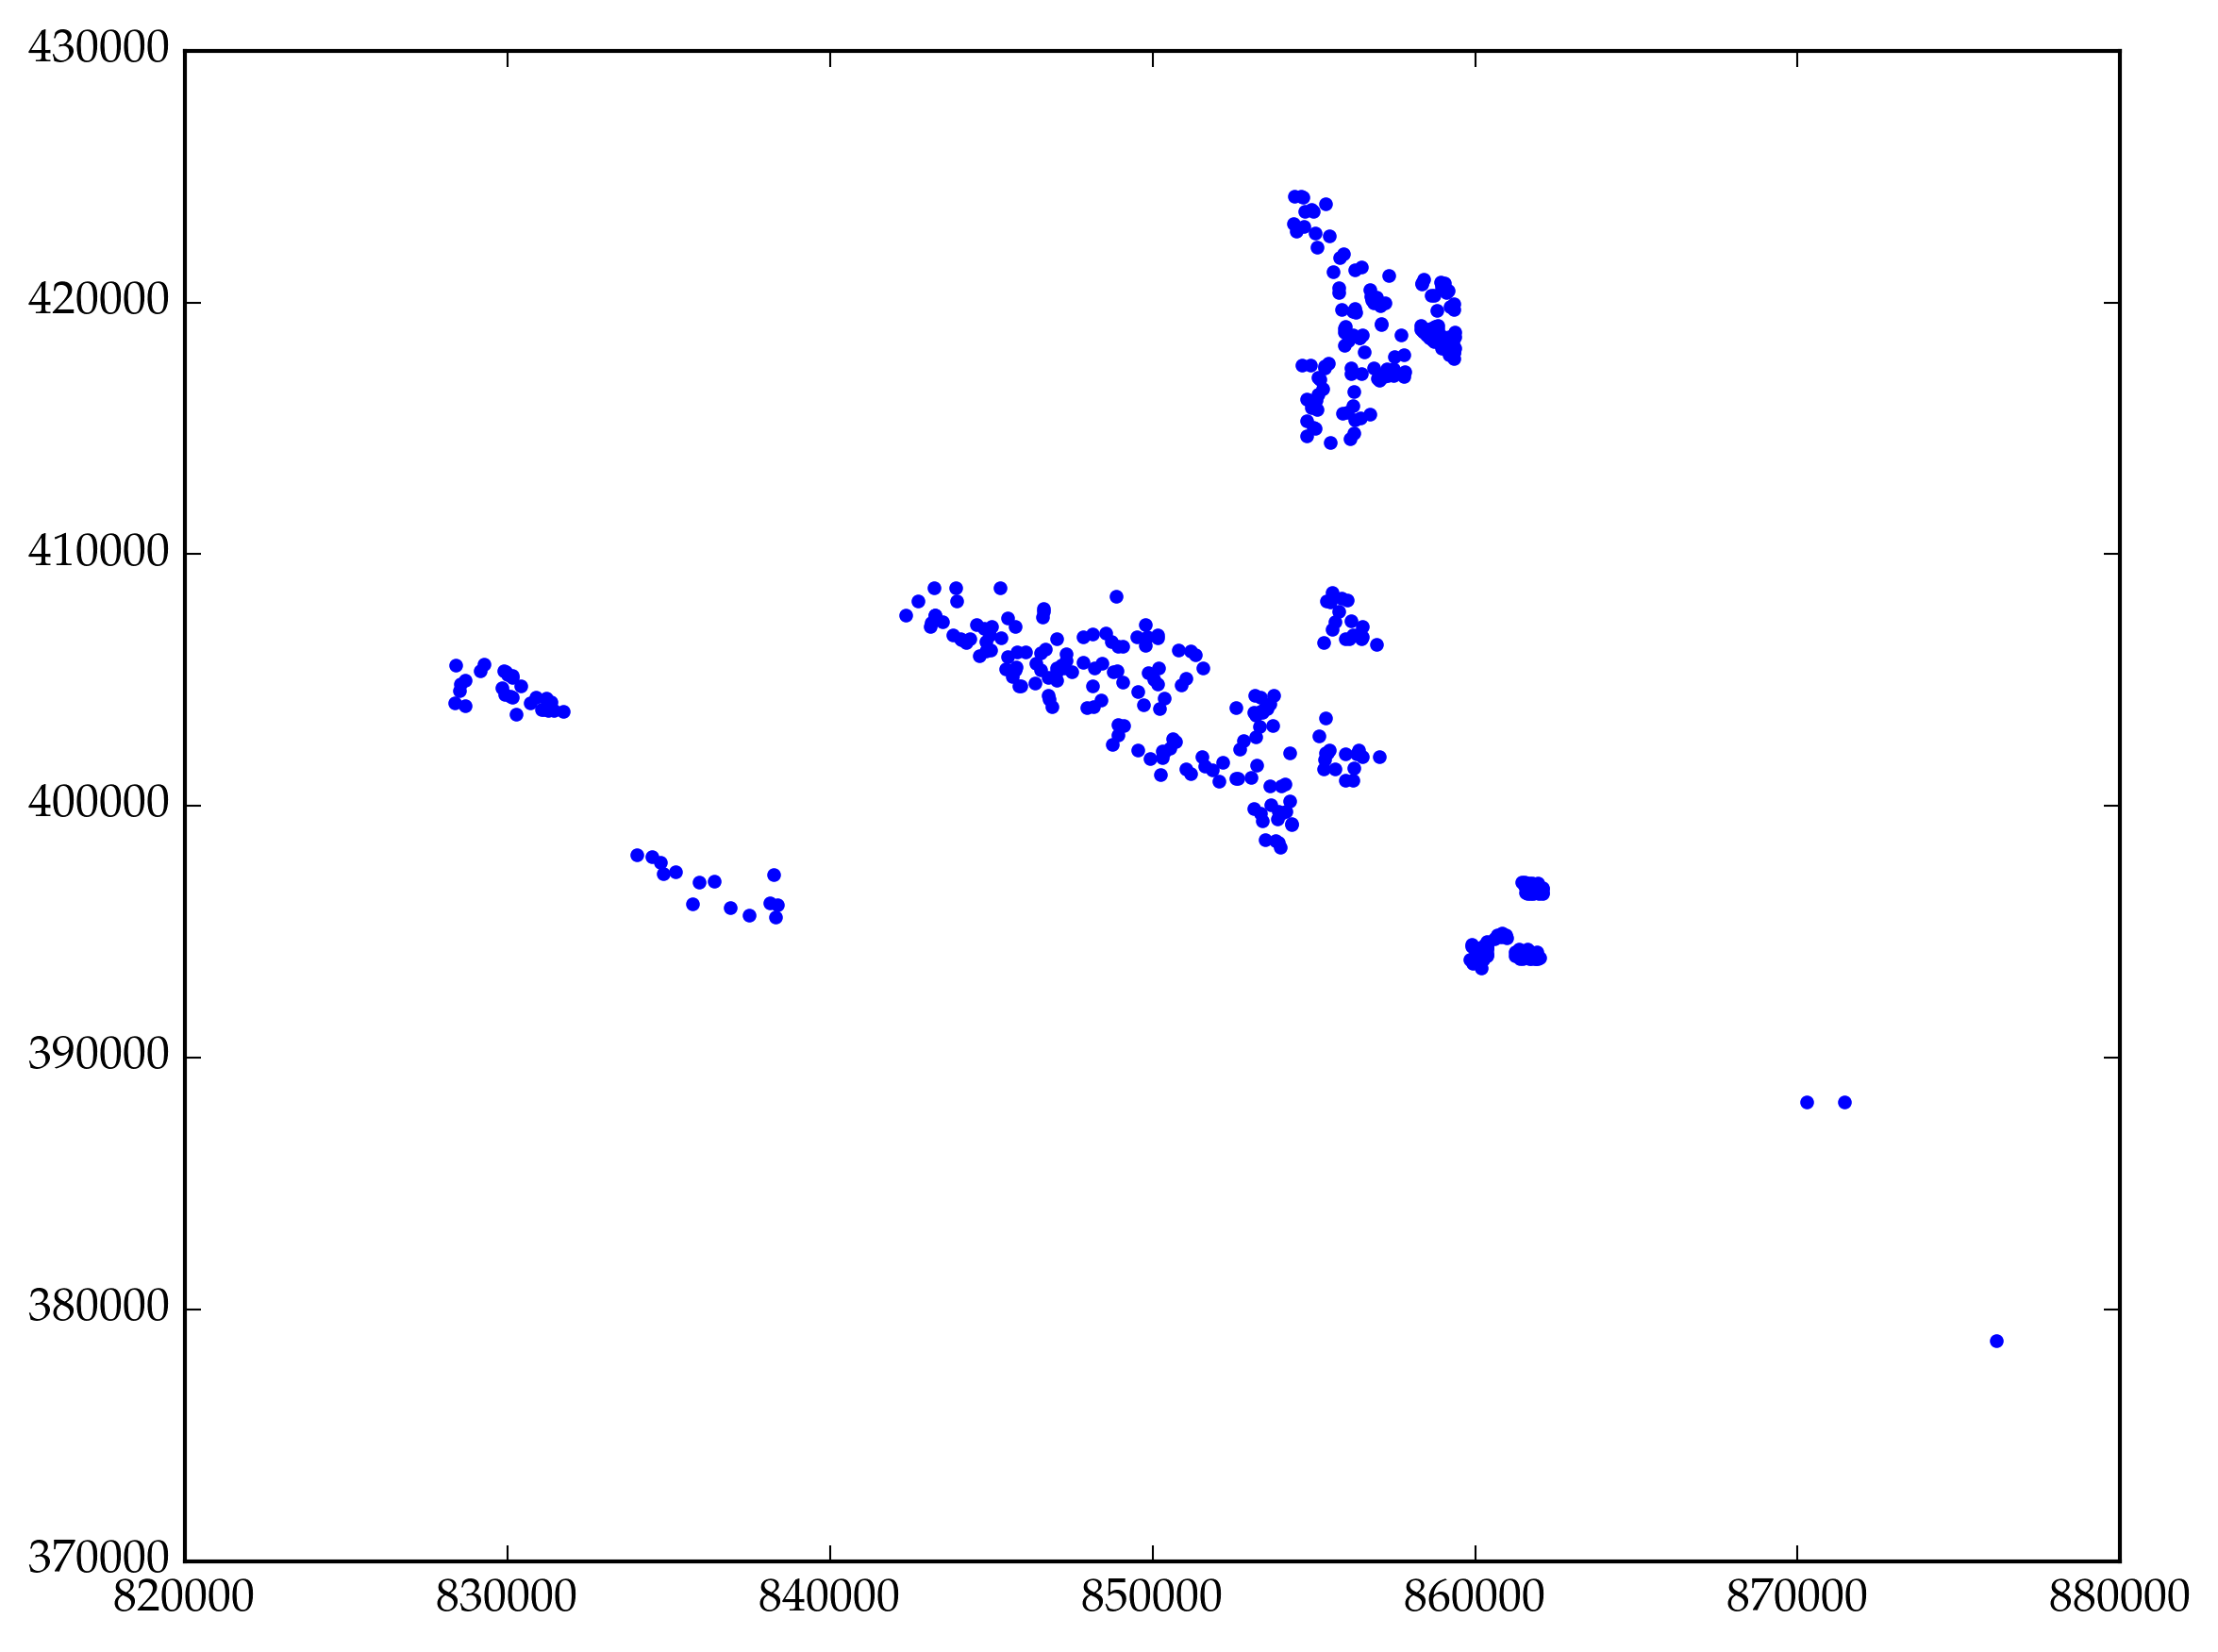

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31db52410>

In [10]:
plt.plot(X_dict["Vail Unified District"][:,1], X_dict["Vail Unified District"][:,2], ".")

In [11]:
std(X_dict["Vail Unified District"],1)

1x2 Array{Float64,2}:
 8626.72  9070.73

In [12]:
std(Y_dict["Vail Unified District"],1)

1-element Array{Float64,1}:
 0.292352

## Boundaries

In [13]:
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
;

In [14]:
sentinels_json.features[1].geometry

GeoJSON.MultiPoint([[787778.4481149958,455984.5341643696],[787751.0865443938,456397.6698585751],[787749.5781172435,456812.8333104904],[787745.7609360296,457227.9974193714],[787739.4065910273,457643.1370777555],[787735.2310601263,458058.3067060452],[787733.2446003554,458473.48214729567],[787730.4144609333,458888.6513425225],[787723.2484005521,459303.7800677075],[787714.9517681954,459718.8883934101]  …  [774413.2665882893,483965.60216168914],[774419.9755080368,484380.7132384444],[774408.9251022419,484795.6946818855],[774394.2752866163,485210.62389735965],[774379.9567833405,485625.5680679589],[774365.642725977,486040.51255899627],[774351.1690942488,486455.45150267304],[774329.0811134004,486870.0242033865],[774266.8216665802,487280.4599729624],[774095.8863404287,487562.1370055481]],#undef,#undef)

In [15]:
sentinels_json.features[1].properties

Dict{UTF8String,Any} with 2 entries:
  "SchoolDistrict2" => "Flowing Wells Unified District"
  "SchoolDistrict1" => "Amphitheater Unified District"

In [16]:
sentinels=Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [17]:
sentinels

Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint} with 20 entries:
  ("Vail Unified District… => GeoJSON.MultiPoint([[827838.9234102826,424598.640…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[732616.9915119059,402400.328…
  ("Flowing Wells Unified… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Vail Unified District… => GeoJSON.MultiPoint([[827978.8141461494,376356.671…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[800840.1244605089,468987.397…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[716932.1348773959,391746.233…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Vail Unified District… => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Amphitheater Unified … => GeoJSON.

# Model with fied hyperparameters
## Fit GPs for each district

Fitting the hyperparameters is a whole other difficult issue. Let's skip ahead, plug in some arbitrary values, and come back to it later.

In [18]:
GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    GP_dict[name] = fit
end

In [19]:
delete!(GP_dict, "Tanque Verde Unified District")

Dict{UTF8String,GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel}} with 5 entries:
  "Flowing Wells Unified … => GP object:…
  "Amphitheater Unified D… => GP object:…
  "Sunnyside Unified Dist… => GP object:…
  "Vail Unified District"  => GP object:…
  "Tucson Unified Distric… => GP object:…

## 2GP posterior

In [20]:
distr1 = "Vail Unified District"
distr2 = "Tucson Unified District"

"Tucson Unified District"

In [21]:
X◫ = hcat(sentinels[distr1,distr2].coordinates...)

2x100 Array{Float64,2}:
 8.59451e5  8.59131e5  8.58812e5  8.58492e5  …  8.28158e5  8.27839e5
 4.24848e5  4.24847e5  4.24847e5  4.24845e5     4.24607e5  4.24599e5

In [22]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [23]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

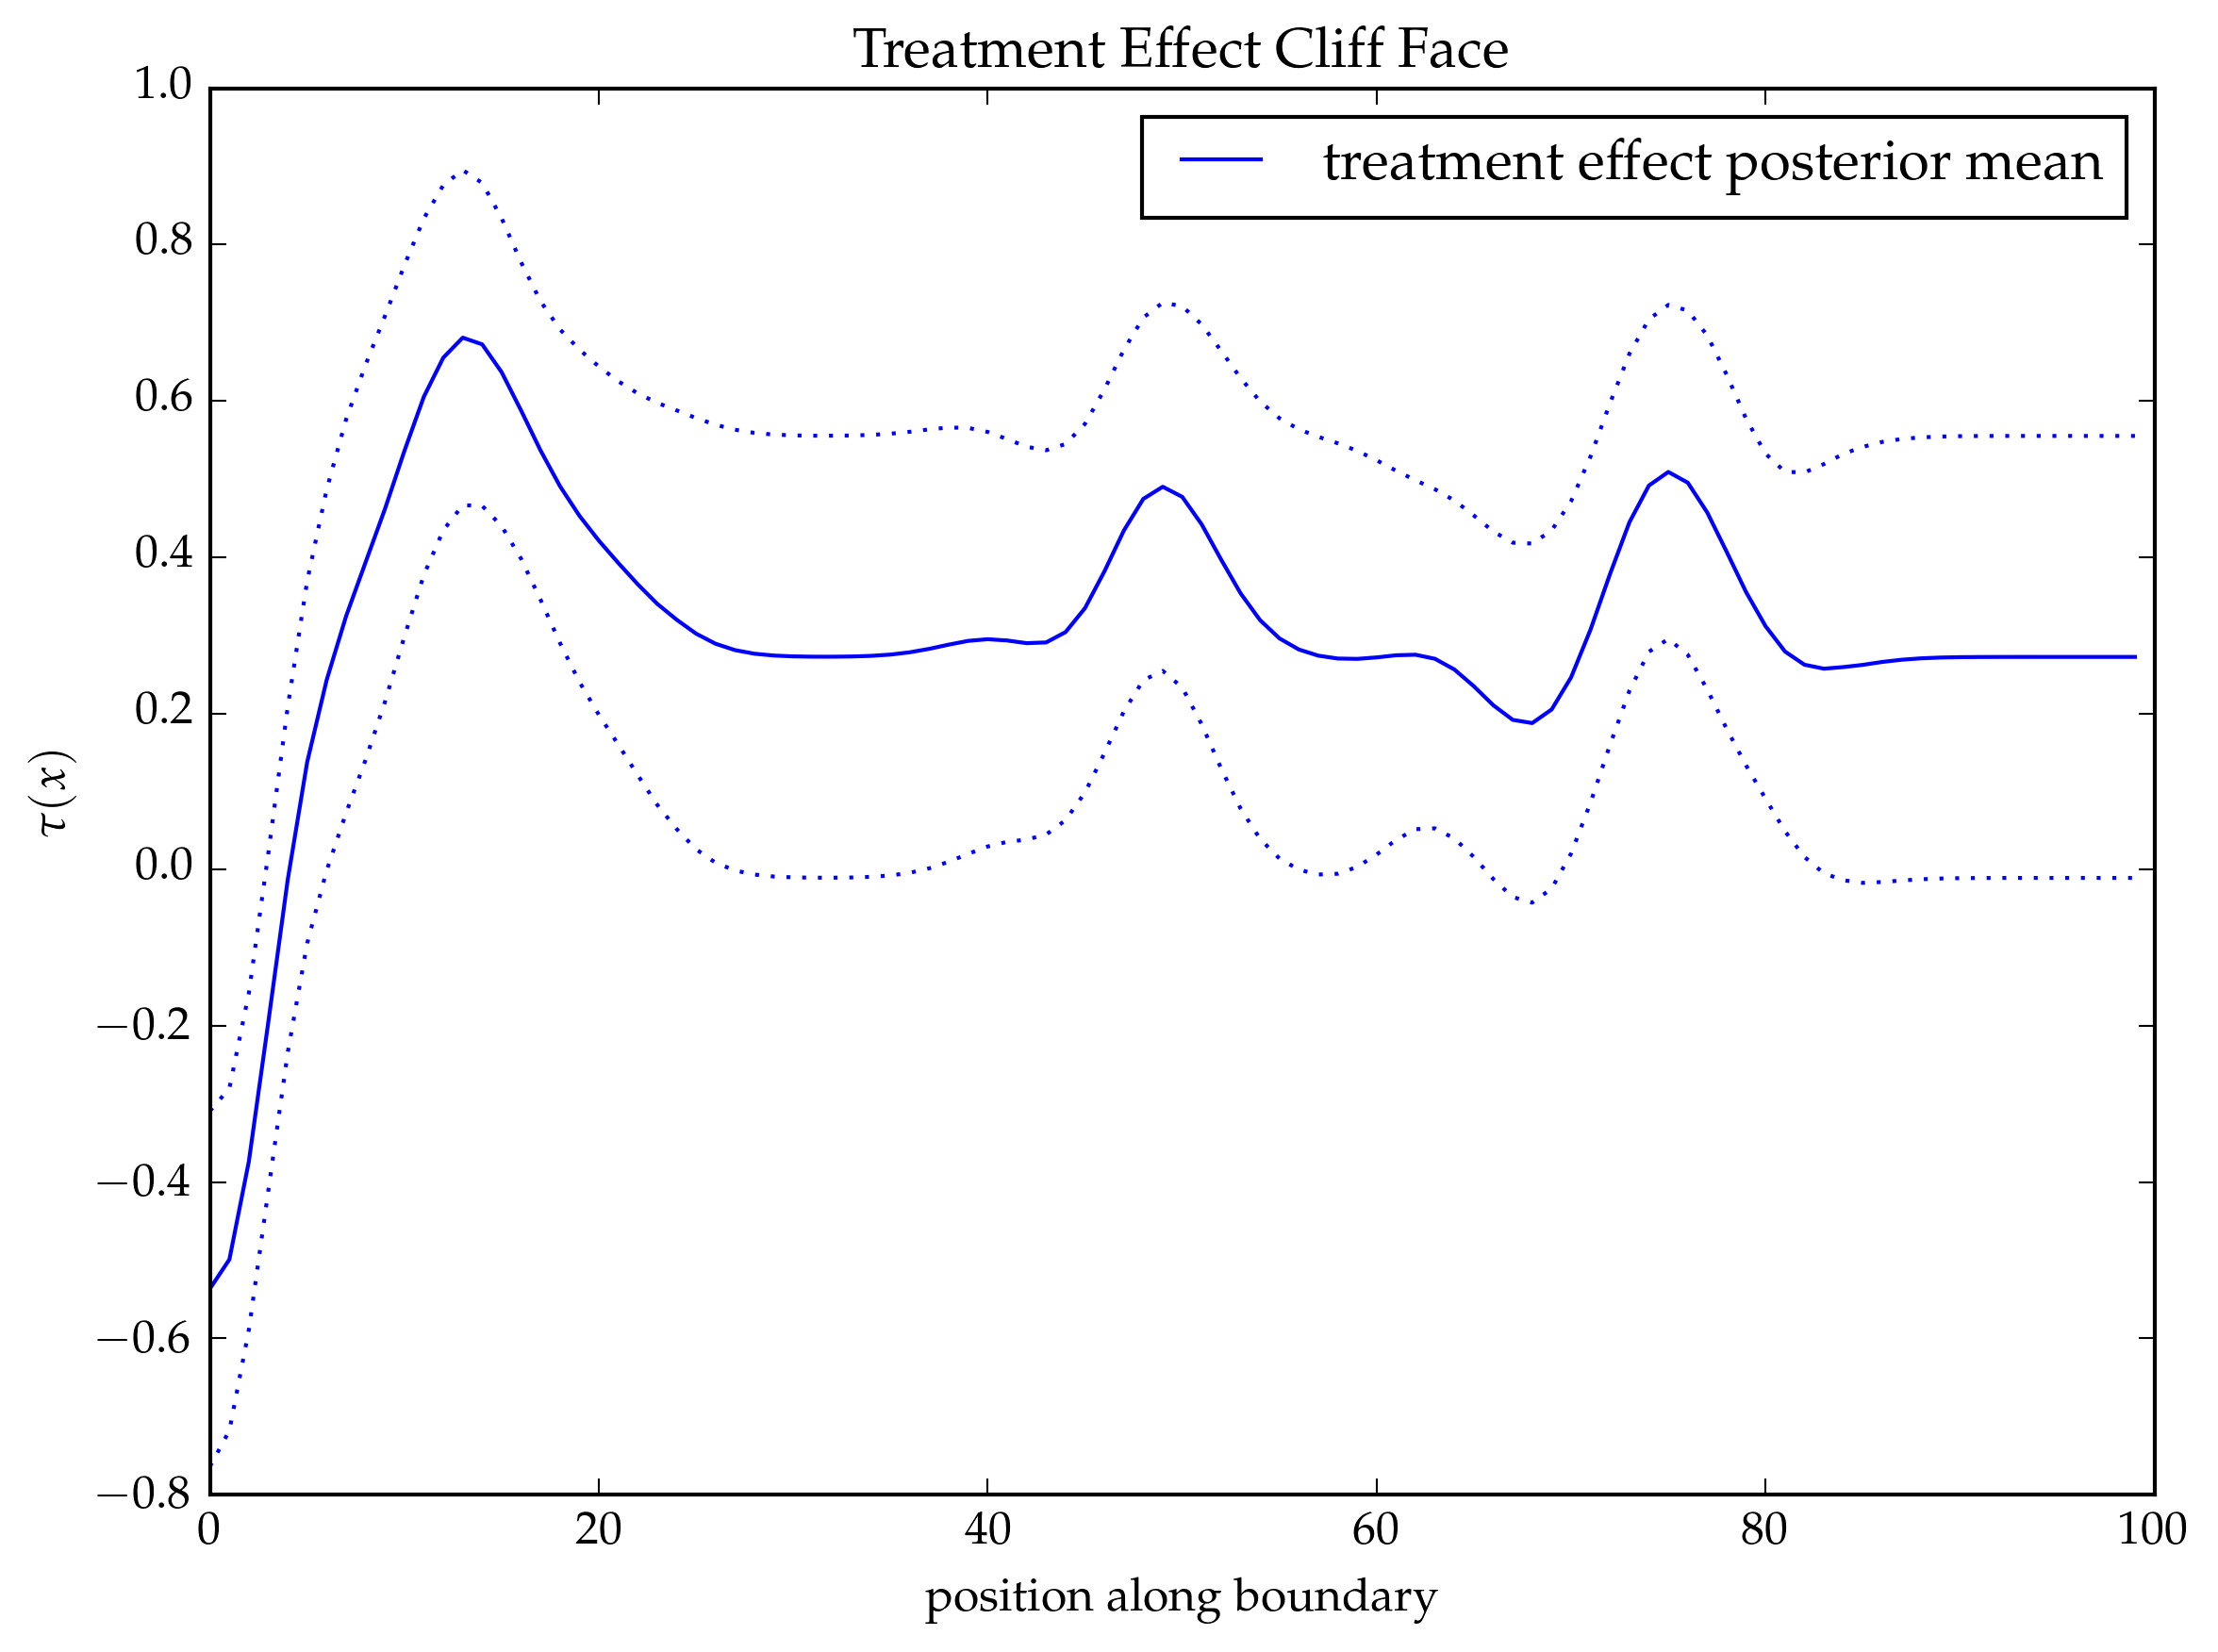

In [24]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

## Inverse-Variance

In [25]:
n◫ = size(X◫)[2]

100

In [26]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=0.2949775000334362, σ=0.0625281936610797)

# Incorporating covariates

# Hyperparameters

Now the difficult part. We need to fit the GP hyperparameters to the data.

In [27]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel},1}

In [28]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gps::MultiGP`: Vector of Gaussian Processes to fit with the same parameters
* `noise::Bool`: Noise hyperparameters should be optimized
* `mean::Bool`: Mean function hyperparameters should be optimized
* `kern::Bool`: Kernel function hyperparameters should be optimized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function optimize!(mgp::MultiGP; noise::Bool=true, mean::Bool=true, kern::Bool=true, method=ConjugateGradient(), kwargs...)
    function mll(hyp::Vector{Float64})
        mLL = 0.0
        println("mll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll!(gp)
                mLL += gp.mLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end  
        println("-mLL: ", -mLL)
        return -mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        println("dmll setting parameters: ", hyp)
        for gp in mgp
            GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
            GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
            grad[:] -= gp.dmLL
        end
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        mLL = 0.0
        println("mll_and_dmll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
                mLL += gp.mLL
                grad[:] -= gp.dmLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end
        println("-mLL: ", -mLL)
        return -mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = GaussianProcesses.get_params(mgp[1];  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    println("initial parameters: ", init)
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    print(results)
end

optimize! (generic function with 1 method)

In [29]:
hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=false, mean=true, kern=false, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10)

initial parameters: [11.771065706252383]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [11.771065706252383]
-mLL: 3808.2053567201415
     0     3.808205e+03     2.090315e+03
mll setting parameters: [-406.29197242924073]
-mLL: 1.0228737545273793e9
mll_and_dmll setting parameters: [-406.29197242924073]
-mLL: 1.0228737545273793e9
mll_and_dmll setting parameters: [-197.26045336149417]
-mLL: 2.5593976566568124e8
mll_and_dmll setting parameters: [-92.74469382762089]
-mLL: 6.409703301034726e7
mll_and_dmll setting parameters: [-40.48681406068425]
-mLL: 1.608173212655907e7
mll_and_dmll setting parameters: [-14.357874177215937]
-mLL: 4.050598045634664e6
mll_and_dmll setting parameters: [-1.293404235481777]
-mLL: 1.0291600954148842e6
mll_and_dmll setting parameters: [5.238830735385303]
-mLL: 266973.3928656001
mll_and_dmll setting parameters: [8.504948220818843]
-mLL: 73013.10973110965
mll_and_dmll setting parameters: [10.138006963535613]
-mLL: 22816.235198902275
mll_an

In [30]:
hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=true, mean=true, kern=false, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10)

initial parameters: [-2.3025850929940455,11.77106388442859]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.3025850929940455,11.77106388442859]
-mLL: 3808.209164925498
     0     3.808209e+03     8.397628e+03
mll setting parameters: [1677.223061947369,-406.296235452247]
-mLL: NaN
mll setting parameters: [165.6499796110423,-30.03566604923897]
-mLL: 669773.6198580224
mll_and_dmll setting parameters: [165.6499796110423,-30.03566604923897]
-mLL: 669773.6198580224
mll_and_dmll setting parameters: [113.4558659501544,-17.043514260469962]
-mLL: 459901.0888275737
mll_and_dmll setting parameters: [55.576640428580184,-2.6362251880206866]
-mLL: 227168.72300533173
mll_and_dmll setting parameters: [37.589687500527994,1.841084728132067]
-mLL: 154843.18528163715
mll_and_dmll setting parameters: [17.64355120376697,6.806074306280329]
-mLL: 74639.77123236094
mll_and_dmll setting parameters: [11.444950385713366,8.349029192522385]
-mLL: 49715.197346022425
mll_and_dmll setting 

In [31]:
hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=false, mean=false, kern=true, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10)

initial parameters: [6.907755278982137,-1.6094379124341003]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [6.907755278982137,-1.6094379124341003]
-mLL: 2116.5868239153538
     0     2.116587e+03     1.758250e+03
mll setting parameters: [282.80921302084073,350.0405022646766]
Base.LinAlg.PosDefException(3)
mll setting parameters: [34.49790105316801,33.55555610527697]
Base.LinAlg.PosDefException(2)
mll setting parameters: [9.666769856400723,1.9070614893370068]
-mLL: 1237.0616650756624
mll_and_dmll setting parameters: [8.420455324099953,0.3185724892698729]
-mLL: 1115.2499726492642
mll_and_dmll setting parameters: [8.420455324099953,0.3185724892698729]
-mLL: 1115.2499726492642
     1     1.115250e+03     1.689517e+02
mll setting parameters: [8.457084561811929,0.2852997915251705]
-mLL: 1104.621973578488
mll_and_dmll setting parameters: [8.75478481766706,0.014879459290145503]
-mLL: 1071.8996232342615
mll_and_dmll setting parameters: [8.75478481766706,0.014879459290

In [32]:
hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=true, mean=true, kern=true, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10)

initial parameters: [-1.0869451143296813,11.468466447490606,8.258970752008336,-0.6847446592906471]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-1.0869451143296813,11.468466447490606,8.258970752008336,-0.6847446592906471]
-mLL: 1023.1678003528757
     0     1.023168e+03     1.313700e+03
mll setting parameters: [-263.82688435633304,-15.487371791929164,8.258970960262634,-0.6847445191365387]
-mLL: 7.624219067976839e9
mll_and_dmll setting parameters: [-263.82688435633304,-15.487371791929164,8.258970960262634,-0.6847445191365387]
-mLL: 7.624219067976839e9
mll_and_dmll setting parameters: [-132.45691473533137,-2.009452672219279,8.258970856135486,-0.6847445892135929]
-mLL: 7.624032628623982e9
mll_and_dmll setting parameters: [-66.77192992483052,4.729506887635663,8.258970804071911,-0.68474462425212]
-mLL: 7.623966223180201e9
mll_and_dmll setting parameters: [-33.9294375195801,8.098986667563135,8.258970778040123,-0.6847446417713835]
-mLL: 7.623939715987193e9
mll_an

I'm not at all that this is anywhere close to a global maximum. The optimization routine has had to do a lot of backtracking, and often ends right where it started.

In [33]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [34]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

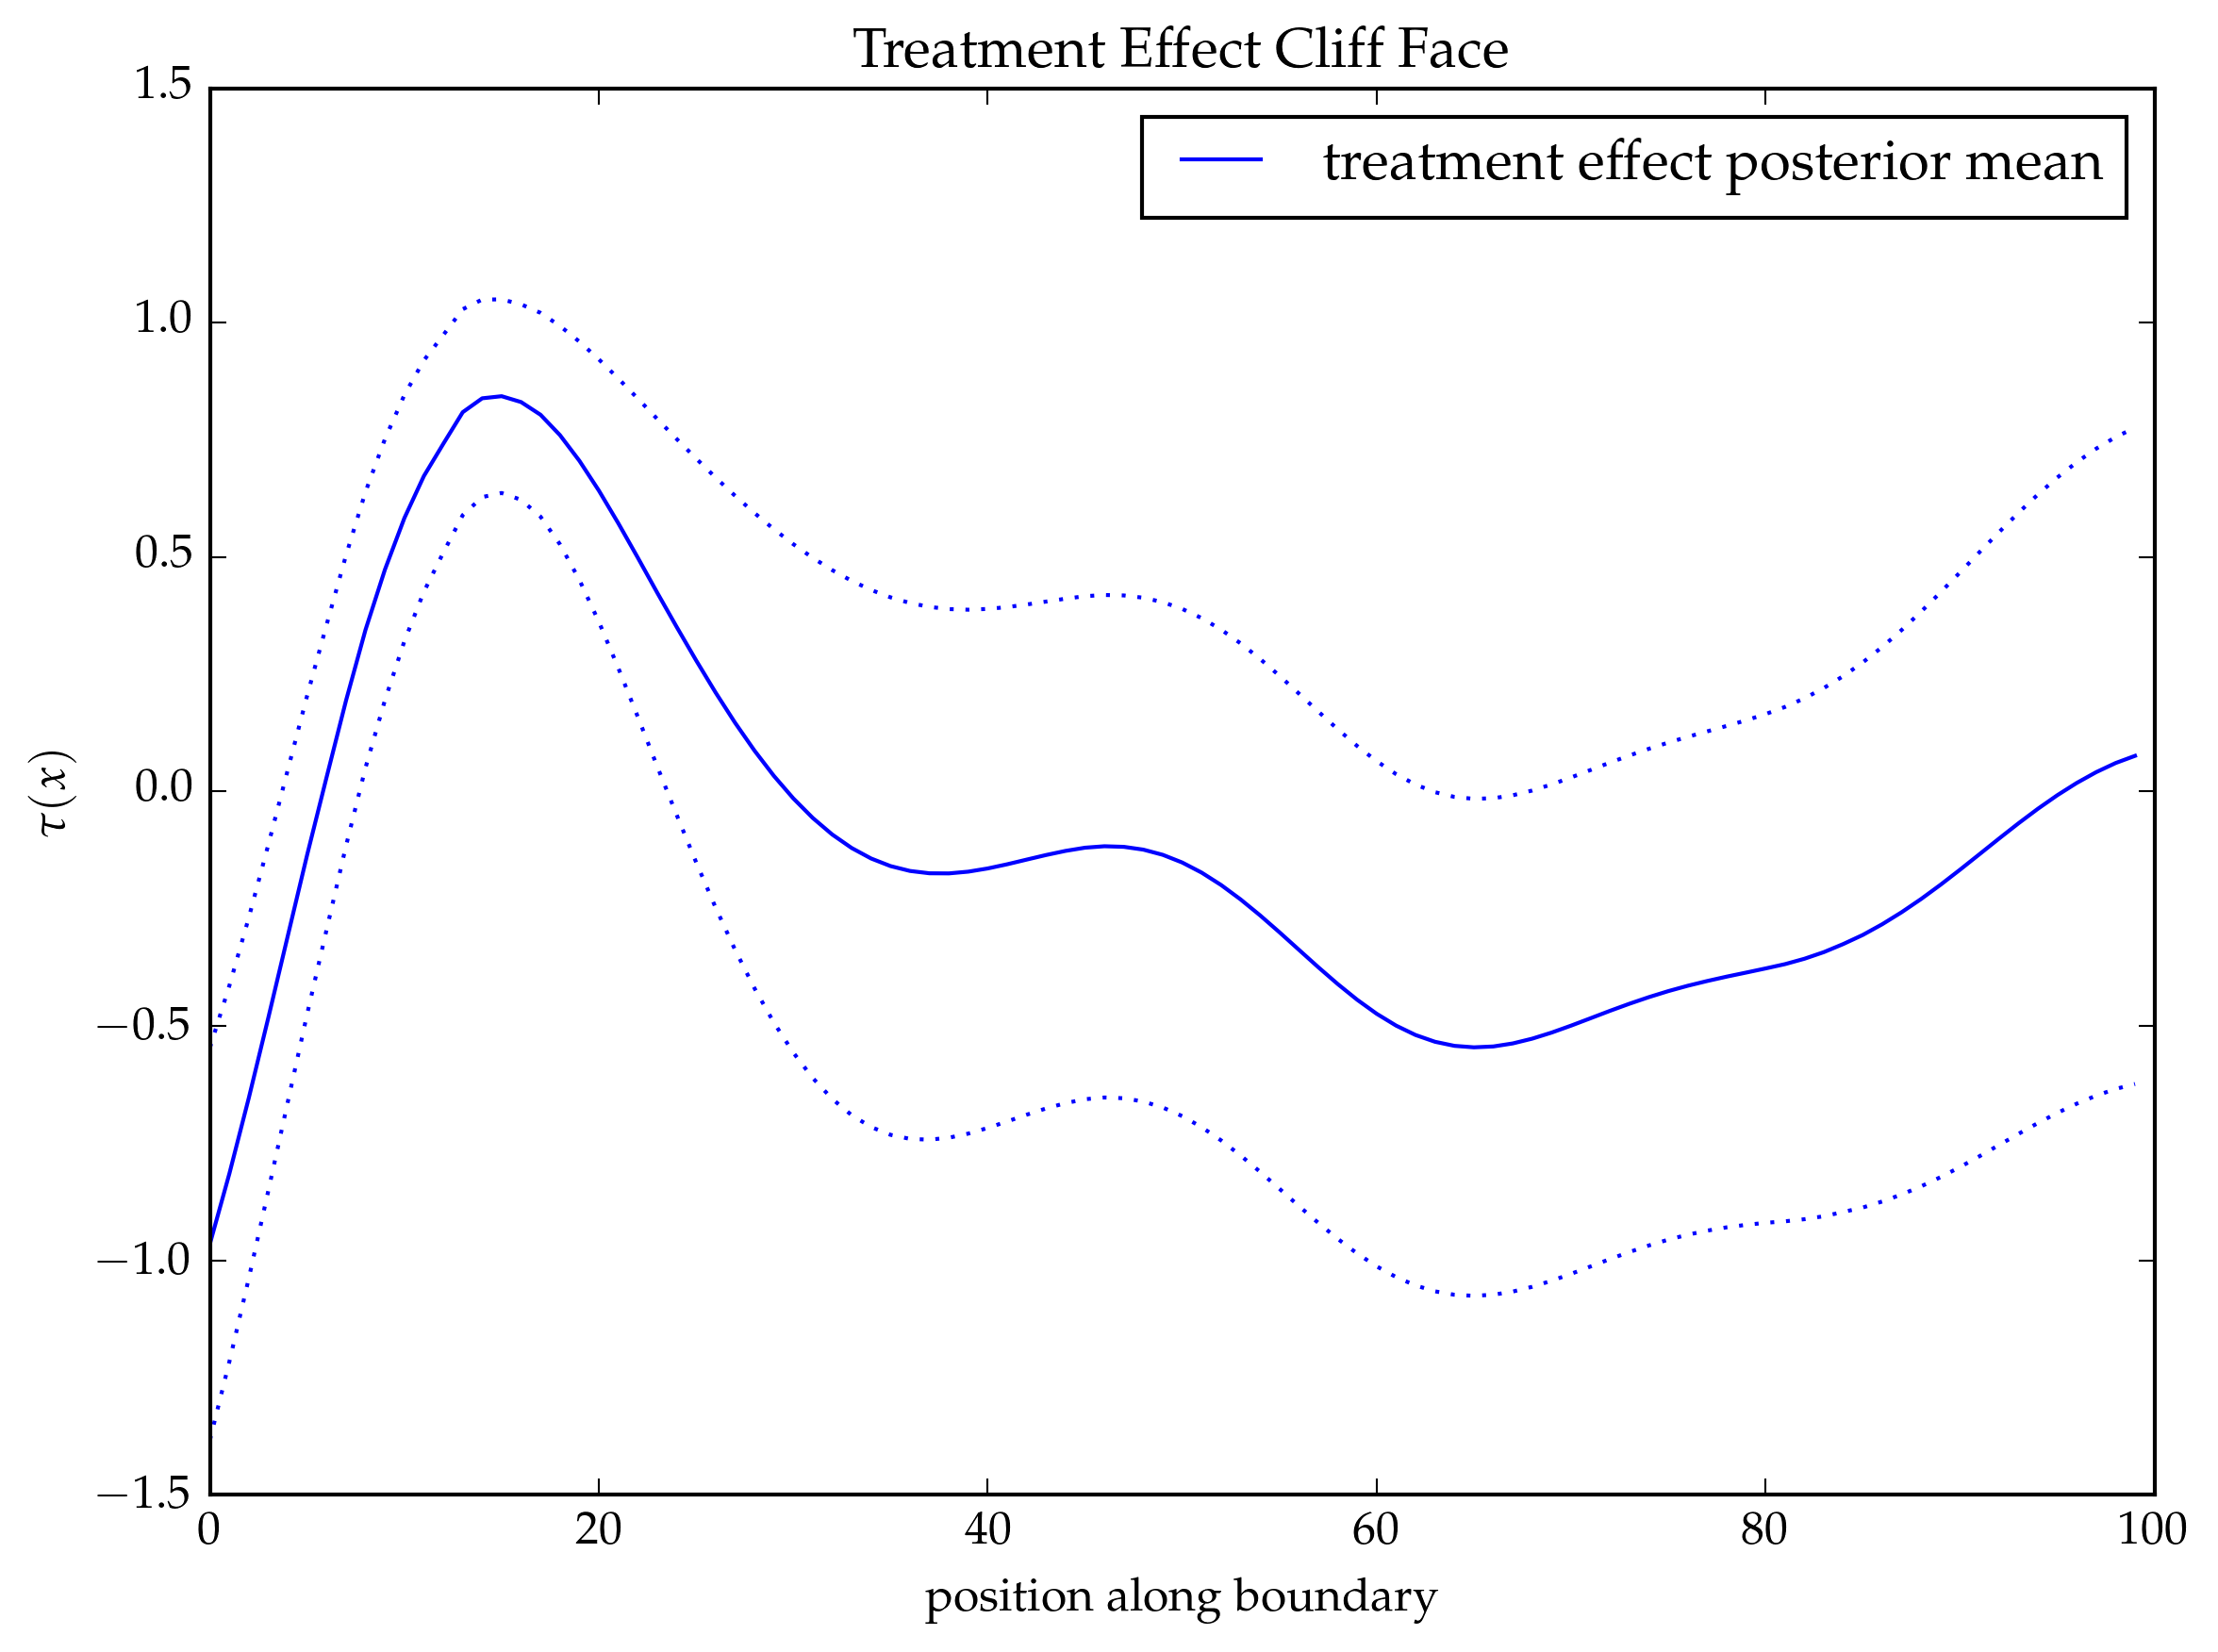

In [35]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [36]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=0.29118317212031375, σ=0.15931398489732412)

This new value of the hyperparameters changes the inverse-variance-weighted mean completely (from positive to negative, and no longer significant). This shows that the choice of hyperparameters is crucial here, and needs to be thought about more carefully.